# Analysis.ipynb

### This notebook analyses the data for the Results section of the thesis.

Author: Erik Puijk <br>
Date  : May 9, 2022

In [3]:
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
plt.close("all")

In [4]:
def read_tweets(path):
    """ Read the Tweets from a given text file and return in JSON-format. """
    
    content = ""
    
    try:
        with open(path, 'r') as f:
            content = json.loads(f.read())
    except IOError:
        print("I/O error")
        
    #print("Total Tweets read: %s\n" % (len(content)))

    return content

In [5]:
def write_csv(headers, rows, path):
    """ Write results from the analysis to a csv-file in a specified path. """
    
    with open(path, 'w') as f:
        w = csv.writer(f)
        
        w.writerow(headers)
        w.writerows(rows)
    
    #print("Total rows written: %s\n" % (len(rows) + 1))

In [6]:
def fix_date(date):
    """ Takes a date in the format yyyy-mm-dd and returns date in format dd-mm. """

    return str(date)[5:10][3:] + '-' + str(date)[5:10][:2]

In [7]:
def average_engagement(tweets):
    """ Count the occurrences and average engagement of each category. """
    
    cat_con = [['cat_con', x, sum(tweets.cat_con == x), 
                "%.1f%%" % round(sum(tweets.cat_con == x) / len(tweets) * 100, 1),
                "%.2f" % round(tweets.loc[tweets['cat_con'] == x, 'total_engagement'].mean() * 1000, 2)]
               for x in sorted(tweets.cat_con.unique())]
    cat_act = [['cat_act', x, sum(tweets.cat_act == x), 
                "%.1f%%" % round(sum(tweets.cat_act == x) / len(tweets) * 100, 1),
                "%.2f" % round(tweets.loc[tweets['cat_act'] == x, 'total_engagement'].mean() * 1000, 2)]
               for x in sorted(tweets.cat_act.unique())]
    media_type = [['media_type', x, sum(tweets.media_type == x), 
                   "%.1f%%" % round(sum(tweets.media_type == x) / len(tweets) * 100, 1), 
                   "%.2f" % round(tweets.loc[tweets['media_type'] == x, 'total_engagement'].mean() * 1000, 2)]
               for x in sorted(tweets.media_type.unique())]
    
    # Write results to a csv file
    write_csv(['Type', 'Category', 'N', 'Percentage', 'Average engagement (x1000)'],
             [*cat_con, *cat_act, *media_type],
             'results/average_engagement.csv')

In [8]:
def plot_overall(x, y1, y2, interval):
    """ Plot the number of Tweets (bar) and the average engagement (line) per time interval in a single figure. """
    
    fig, ax1 = plt.subplots(figsize = (6, 4.5))
    ax1.bar([fix_date(date) for date in x], y1, width = 0.5, label='Number of Tweets')
    ax2 = ax1.twinx()
    # Multiply engagement by 1000
    ax2.plot([fix_date(date) for date in x], [number*1000 for number in y2], '-r')
    ax1.plot(np.nan, '-r', label = 'Average engagement')
    
    ax1.legend()
    
    if interval == 'day':
        plt.xticks(np.arange(0, len(x), 7.0))
    
    # Set labels and title
    ax1.set_xlabel(interval.capitalize())
    ax1.set_ylabel('Number of Tweets')
    ax2.set_ylabel('Average engagement (x1000)')
    ax2.set_ylim(ymin=0)
    plt.title('Number of Tweets and average engagement')
    
    plt.savefig('results/overall_%s.png' % interval)
    plt.show()

In [9]:
def plot_categories(ylabel, title, x, y, labels, interval, filename):
    """ Plot the occurrence of messaging strategies relative to the total number of Tweets posted in the time
    interval. """

    fig, ax = plt.subplots(figsize = (6, 4))
    
    # Multiply ratios in y by 100 to get a percentage
    if len(labels) == 0:
        ax.plot([fix_date(date) for date in x], [number*100 for number in y])
    else:
        for i, label in enumerate(labels):
            ax.plot([fix_date(date) for date in x],[[number*100 for number in lst][i] for lst in y], label=label)
    
    if interval == 'day':
        plt.xticks(np.arange(0, len(x), 7.0))
    
    # Set labels and title
    ax.set_xlabel(interval.capitalize())
    ax.set_ylabel(ylabel)
    ax.set_ylim(ymin=0)
    plt.title(title)
    
    # Only generate legend if more than one labels
    if len(labels) > 0:
        ax.legend()
    
    plt.savefig('results/%s_%s.png' % (filename, interval))
    plt.show()

In [10]:
def engagement_per_week(tweets, interval):
    
    # Copy selection of data frame
    df = tweets[['created_at', 'cat_con', 'cat_act', 'media_type', 'total_engagement']].copy()
    
    # Insert temporary column with creation date (without time)
    df.insert(0, 'temp', pd.to_datetime(df.created_at.str[:10], format='%Y-%m-%d'))
    
    # Creation date with time can be removed
    del df['created_at']
    
    # List and sort all days
    dates = sorted(pd.to_datetime(df.temp.unique()))
    
    if interval == 'week':
        # If interval is week, only keep week starting dates (Thursdays)
        dates = [date for i, date in enumerate(dates) if i % 7 == 0]  
    
    df.insert(0, 'date', "")
    
    # Insert week start date as column
    for i, date in enumerate(dates):

        if interval == 'week':
            # Compare if date is equal to or larger than the checked start date, use that start date
            df.loc[df.temp >= dates[i], 'date'] = date.date()
        else:
            df.loc[df.temp == dates[i], 'date'] = date.date()

    # Delete temporary column
    del df['temp']
            
    num_tweets = []
    avg_engagement = []
    cat_con = []
    cat_act = []
    media_type = []
    # Create copy of original dates without time
    dates2 = [date.date() for date in dates]
        
    for i, date in enumerate(dates2):
        # Make lists that will be plotted on y-axes
        num_tweets.append(len(df[df['date'] == date]))
        avg_engagement.append(df[df['date'] == date]['total_engagement'].mean())
        cat_con.append([len(df[(df['date'] == date) & (df['cat_con'] == 'CAM')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_con'] == 'POL')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_con'] == 'SOC')]) / num_tweets[i]])
        cat_act.append([len(df[(df['date'] == date) & (df['cat_act'] == 'CON')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_act'] == 'FOL')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_act'] == 'NONE')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['cat_act'] == 'SUP')]) / num_tweets[i]])
        media_type.append([len(df[(df['date'] == date) & (df['media_type'] == 'animated_gif')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['media_type'] == 'none')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['media_type'] == 'photo')]) / num_tweets[i],
                       len(df[(df['date'] == date) & (df['media_type'] == 'video')]) / num_tweets[i]])
    
    # Plot the lists
    plot_overall(dates2, num_tweets, avg_engagement, interval)
    plot_categories('Percentage of Tweets', 'Occurrence of content type strategies', dates2, cat_con, 
               ['CAM', 'POL', 'SOC'], interval, 'cat_con')
    plot_categories('Percentage of Tweets', 'Occurrence of activation type strategies', dates2, cat_act, 
               ['CON', 'FOL', 'NONE', 'SUP'], interval, 'cat_act')
    plot_categories('Percentage of Tweets', 'Occurrence of media type strategies', dates2, media_type, 
               ['animated_gif', 'none', 'photo', 'video'], interval, 'media_type')

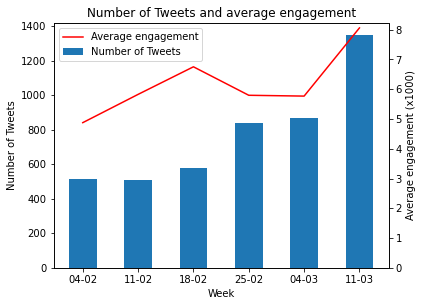

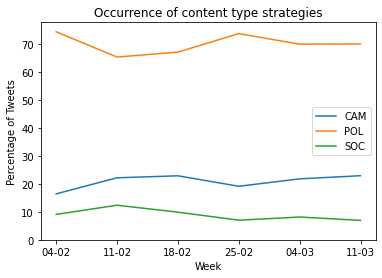

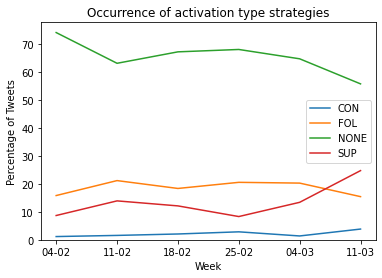

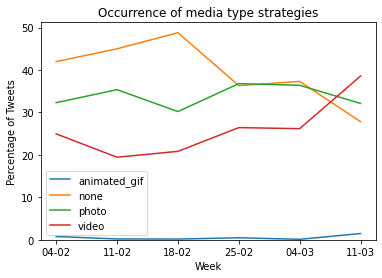

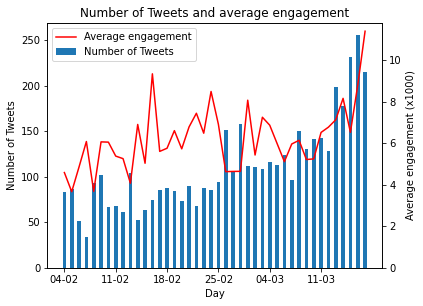

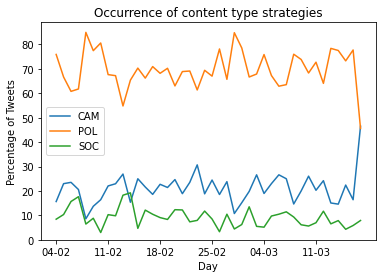

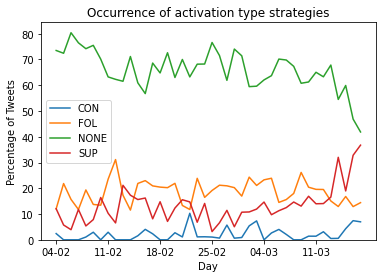

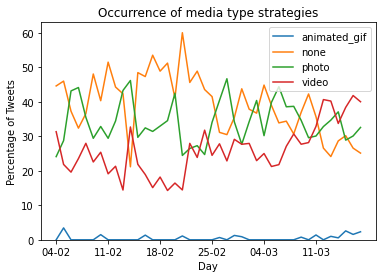

In [11]:
tweets = read_tweets('source/tweets_all_labeled.txt')
tweets_pd = pd.DataFrame(tweets)

# Show the number of Tweets and average engagement per messaging strategy
average_engagement(tweets_pd)

engagement_per_week(tweets_pd, 'week')
#engagement_per_week(tweets_pd, 'day')